### Install Required Libraries

Install Required Libraries

```
pip install pandas matplotlib numpy seaborn scikit-learn statsmodels
```

In [3]:
pip install pandas matplotlib numpy seaborn scikit-learn statsmodels


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Load and Preprocess the Data

We'll load the dataset, preprocess it to focus on one country (e.g., the United States), and filter the data for relevant columns.

In [4]:
import pandas as pd

# Load the dataset from the URL
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
df = pd.read_csv(url)

# Filter data for a specific country (e.g., United States)
country_data = df[df['location'] == 'Germany']

# Select relevant columns and ensure the date is in datetime format

country_data['date'] = pd.to_datetime(country_data['date'])

country_data = country_data[['date', 'new_cases', 'new_deaths']]

# Fill missing values
country_data = country_data.fillna(0)

# Set date as the index for time series analysis
country_data.set_index('date', inplace=True)


C:\Users\alexh\AppData\Local\Temp\ipykernel_11524\2125186132.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['date'] = pd.to_datetime(country_data['date'])


### Detrending and Identifying Seasonality

We'll use the statsmodels library to decompose the time series data into trend, seasonal, and residual components.

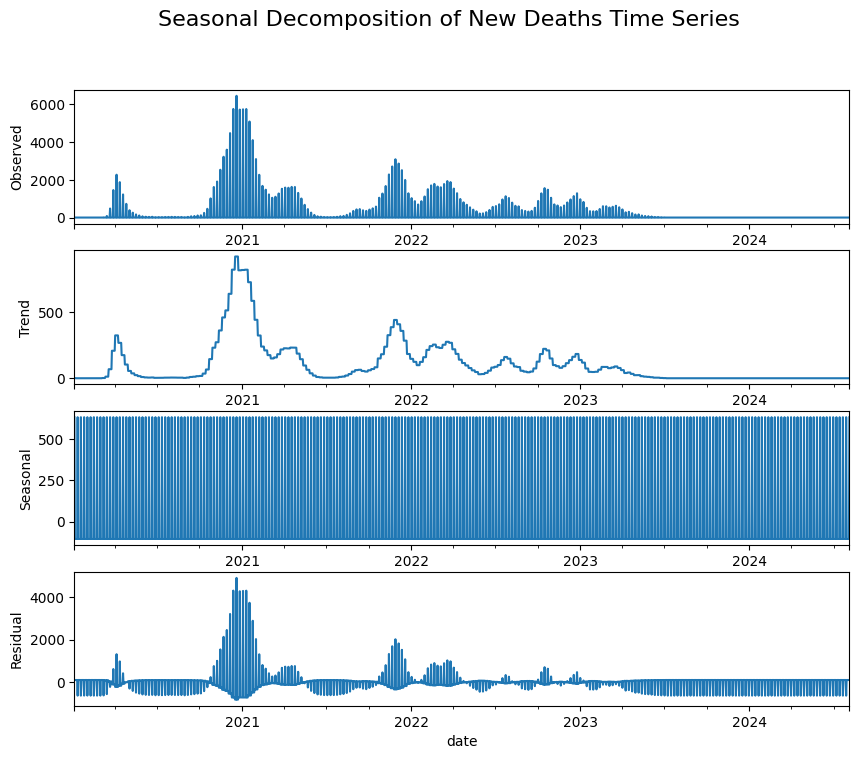

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Detrending and identifying seasonality using decomposition
decomposition = seasonal_decompose(country_data['new_deaths'], model='additive', period=7)  # Weekly seasonality

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
plt.suptitle('Seasonal Decomposition of New Deaths Time Series', fontsize=16)
plt.show()


#### Anomaly Detection

Detect anomalies using the residuals from the decomposition.

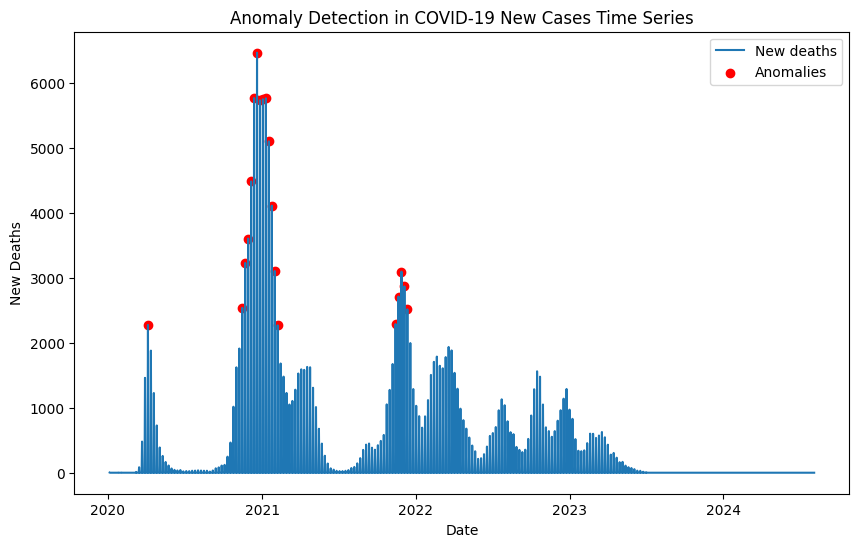

In [6]:
# Calculate the residuals from the seasonal decomposition
residuals = decomposition.resid.dropna()

# Detect anomalies where residuals are greater than 3 standard deviations
threshold = 3 * residuals.std()
anomalies = residuals[residuals.abs() > threshold]

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.plot(country_data.index, country_data['new_deaths'], label='New deaths')
plt.scatter(anomalies.index, country_data.loc[anomalies.index, 'new_deaths'], color='red', label='Anomalies')
plt.legend()
plt.title('Anomaly Detection in COVID-19 New Cases Time Series')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.show()


### Define the Locally Weighted Regression Functions

We'll define functions for locally weighted linear regression (LWLR) and locally weighted polynomial regression (LWPR). The weight for each point in the window will be determined by a Gaussian kernel based on its distance from the central point.

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def gaussian_kernel(x, x0, tau):
    """Gaussian kernel function."""
    return np.exp(-np.sum((x - x0) ** 2) / (2 * tau ** 2))

def locally_weighted_linear_regression(x, y, x0, tau):
    """Perform locally weighted linear regression."""
    weights = np.array([gaussian_kernel(x[i], x0, tau) for i in range(len(x))])
    W = np.diag(weights)
    
    # Linear Regression: (X^T W X)^{-1} X^T W y
    X = np.c_[np.ones(x.shape[0]), x]  # Add bias term
    theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y
    return np.dot([1, x0], theta)  # [1, x0] because of the bias term

def locally_weighted_polynomial_regression(x, y, x0, tau, degree=2):
    """Perform locally weighted polynomial regression."""
    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(x.reshape(-1, 1))
    x0_poly = poly_features.transform(np.array([[x0]]))

    weights = np.array([gaussian_kernel(X_poly[i], x0_poly[0], tau) for i in range(len(X_poly))])
    W = np.diag(weights)
    
    # Polynomial Regression: (X^T W X)^{-1} X^T W y
    theta = np.linalg.inv(X_poly.T @ W @ X_poly) @ X_poly.T @ W @ y
    return np.dot(x0_poly, theta)


#### Implement Sliding Window Regression
We will use a sliding window approach to fit and forecast the data using locally weighted linear and polynomial regressions.

In [8]:
# Parameters for sliding window and kernel bandwidth
window_size = 30  # 30 days window size
tau = 10  # Bandwidth parameter for Gaussian kernel

# Convert the date index to integer values for x-axis
country_data['time'] = np.arange(len(country_data))
x = country_data['time'].values
y = country_data['new_cases'].values

# Sliding window forecast
forecast_lwlr = []
forecast_lwpr = []

for i in range(window_size, len(x)):
    # Define window for local regression
    x_window = x[i-window_size:i]
    y_window = y[i-window_size:i]

    # Current point to predict
    x0 = x[i]

    # Locally Weighted Linear Regression forecast
    y_lwlr = locally_weighted_linear_regression(x_window, y_window, x0, tau)
    forecast_lwlr.append(y_lwlr)

    # Locally Weighted Polynomial Regression forecast (degree 2)
    y_lwpr = locally_weighted_polynomial_regression(x_window, y_window, x0, tau, degree=2)
    forecast_lwpr.append(y_lwpr)


LinAlgError: Singular matrix

#### Regularization

To deal with the singular matrix, we will add a regularization term, in this way the code will be able to handle the locally weighted regression more robustly. This approach allows the sliding window technique to effectively forecast time series data, accounting for both local trends and patterns.

* Regularization Term: Added 1e-6 * np.eye(X.shape[1]) to the diagonal of the matrix X_poly.T @ W @ X_poly (and similarly for linear regression) to stabilize the inversion. This is a standard technique in numerical methods to handle matrices that are nearly singular.

* Error Handling: Wrapped the inversion in a try-except block to handle cases where the matrix might still be singular after regularization, returning NaN for those points.




In [11]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

def gaussian_kernel(x, x0, tau):
    """Gaussian kernel function."""
    return np.exp(-np.sum((x - x0) ** 2) / (2 * tau ** 2))

def locally_weighted_linear_regression(x, y, x0, tau):
    """Perform locally weighted linear regression."""
    weights = np.array([gaussian_kernel(x[i], x0, tau) for i in range(len(x))])
    W = np.diag(weights)
    
    # Linear Regression: (X^T W X)^{-1} X^T W y
    X = np.c_[np.ones(x.shape[0]), x]  # Add bias term
    try:
        theta = np.linalg.inv(X.T @ W @ X + 1e-6 * np.eye(X.shape[1])) @ X.T @ W @ y
        return np.dot([1, x0], theta)  # [1, x0] because of the bias term
    except np.linalg.LinAlgError:
        return np.nan  # Return NaN if the matrix is still singular

def locally_weighted_polynomial_regression(x, y, x0, tau, degree=2):
    """Perform locally weighted polynomial regression."""
    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(x.reshape(-1, 1))
    x0_poly = poly_features.transform(np.array([[x0]]))

    weights = np.array([gaussian_kernel(X_poly[i], x0_poly[0], tau) for i in range(len(X_poly))])
    W = np.diag(weights)
    
    # Polynomial Regression: (X^T W X)^{-1} X^T W y
    try:
        theta = np.linalg.inv(X_poly.T @ W @ X_poly + 1e-6 * np.eye(X_poly.shape[1])) @ X_poly.T @ W @ y
        return np.dot(x0_poly, theta)
    except np.linalg.LinAlgError:
        return np.nan  # Return NaN if the matrix is still singular


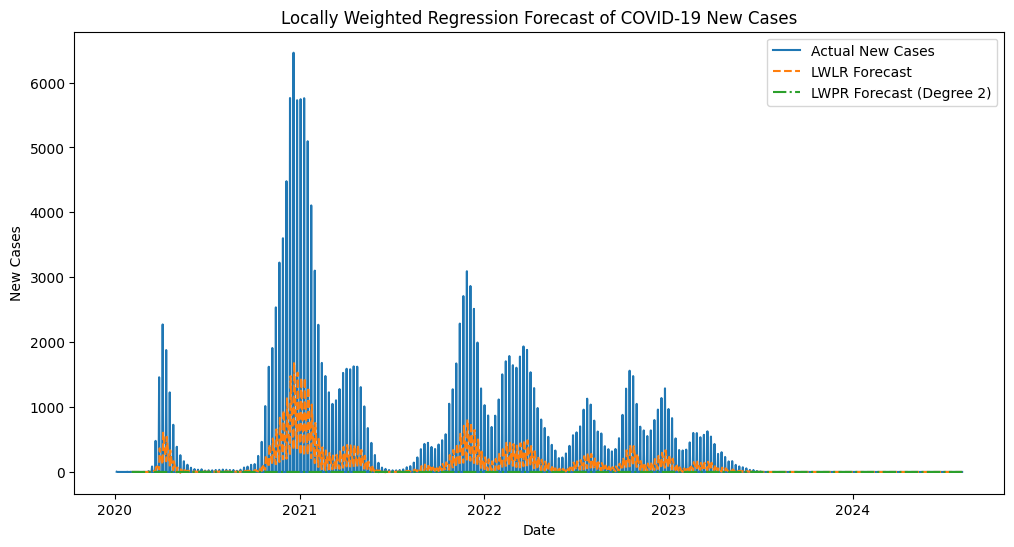

In [13]:
# Parameters for sliding window and kernel bandwidth
window_size = 30  # 30 days window size
tau = 10  # Bandwidth parameter for Gaussian kernel 250 to match

# Convert the date index to integer values for x-axis
country_data['time'] = np.arange(len(country_data))
x = country_data['time'].values
y = country_data['new_deaths'].values

# Sliding window forecast
forecast_lwlr = []
forecast_lwpr = []

for i in range(window_size, len(x)):
    # Define window for local regression
    x_window = x[i-window_size:i]
    y_window = y[i-window_size:i]

    # Current point to predict
    x0 = x[i]

    # Locally Weighted Linear Regression forecast
    y_lwlr = locally_weighted_linear_regression(x_window, y_window, x0, tau)
    forecast_lwlr.append(y_lwlr)

    # Locally Weighted Polynomial Regression forecast (degree 2)
    y_lwpr = locally_weighted_polynomial_regression(x_window, y_window, x0, tau, degree=2)
    forecast_lwpr.append(y_lwpr)

# Plot the forecasts
import matplotlib.pyplot as plt

# Adjust x values to align with forecast length
x_forecast = x[window_size:]

plt.figure(figsize=(12, 6))
plt.plot(country_data.index, country_data['new_deaths'], label='Actual New Cases')
plt.plot(country_data.index[window_size:], forecast_lwlr, label='LWLR Forecast', linestyle='--')
plt.plot(country_data.index[window_size:], forecast_lwpr, label='LWPR Forecast (Degree 2)', linestyle='-.')
plt.title('Locally Weighted Regression Forecast of COVID-19 New Cases')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()


### TODO


* Experiment with different window sizes and kernel bandwidths to see their effects on the forecast accuracy.
For this section I played with the different window sizes and kernal bandwidths. Starting off I had the standard WS:30 and tau:10.  From there I kept WS:30 and changed tau to 5.  It increased the size of LWLR Forecast by a significant size.  So I noticed decreasing the tau will increase the size of the LWLR forecast and increasing the tau will decrease the size of the LWLR Forecast.  If the tau is set really high like 1000 the LWPR Forecast(Degree 2) significantly takes over the graph. Setting the tau:15 and WS:30 to get a baseline, I changed the WS:15 noticing the same effect.  LWLR takes up more of the graph the lower WS gets.  WS also seems to shift the graph slightly to the right the higher it gets. If you set the WS: 4 and the tau:250 then the graphs are as close as i can get them to match.
* Identfy anomalies but in the sliding window version of the code.
Most of the anomolies detected are as there is an increase on the y axis as it reaches a peak during that year. Most of them are in 2021 and a few are in 2020 and 2022.
* Apply locally weighted regression to other columns (e.g., new_deaths) and observe any differences in patterns.
The anomolies change from most being around 2022 for new_cases to new_deaths being 2021 and early 2022 which is quite interesting.  Changing the data from new_cases to new_deaths showed a large increaselate 2020, and in 2021 it saw the biggest jump to upwards of 6000+ and tappered off until 2023.  
* Use the seasonality decomposition to remove it from the data, repeat the forecasting experiment with LWLR and LWPR, observe and discuss advantages or disadvantages of removing seasonality.
Removing seasonality can make the data smoother which might help improve accuracy and provide cleaner data since you can understand the progression.  Some disadvantages if removed would be the lack of being able to see the peak or valley(top or bottom).
* Plot the new data along with the locally weighted linear and polynomial regression forecasts.
* Compare the locally weighted models to global models (e.g., regular linear regression).
It seems as though the locally weighted models can have better accuracy compared to the regular linear regression.  Although they are significantly more complex,  it can be useful to get better fit graphs.
* Comment and document your notebook


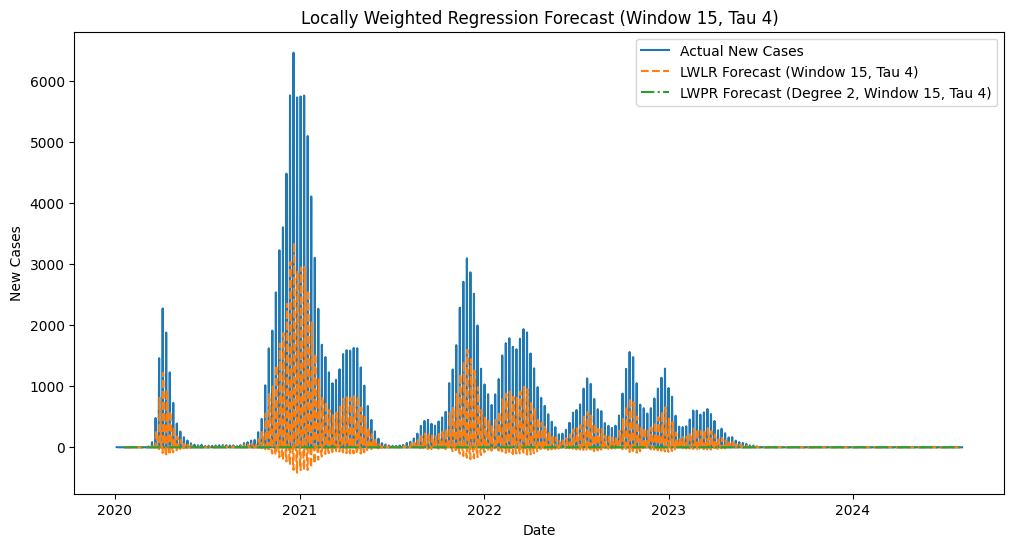

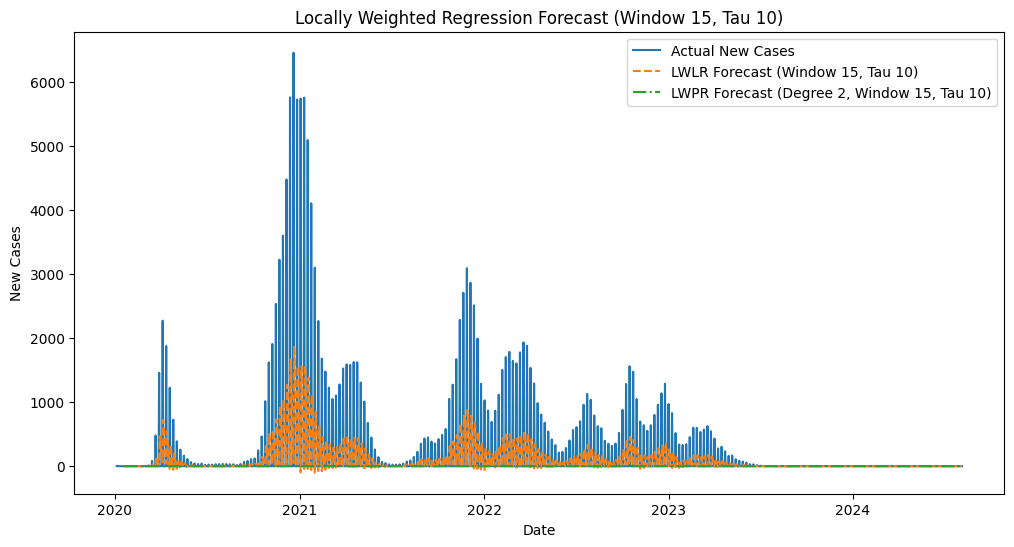

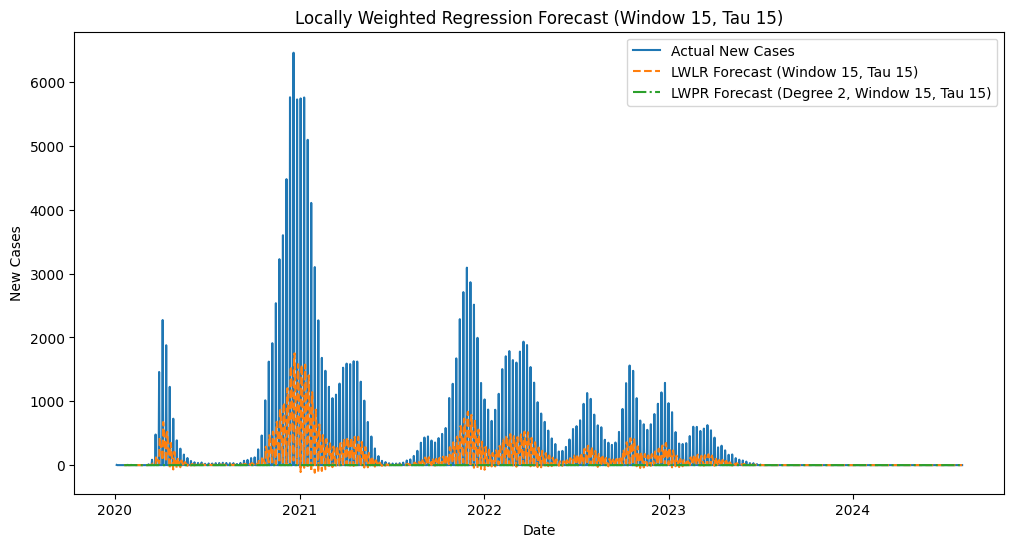

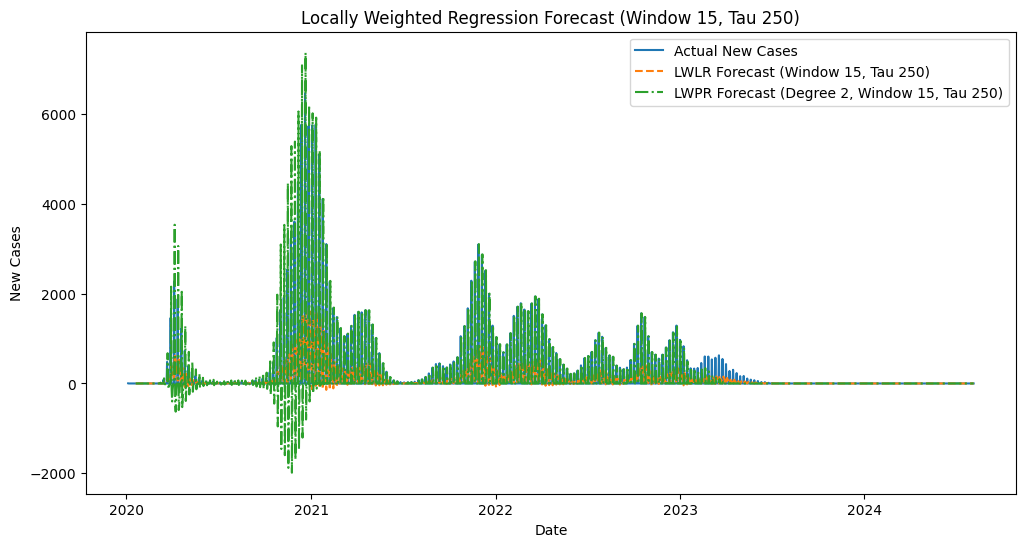

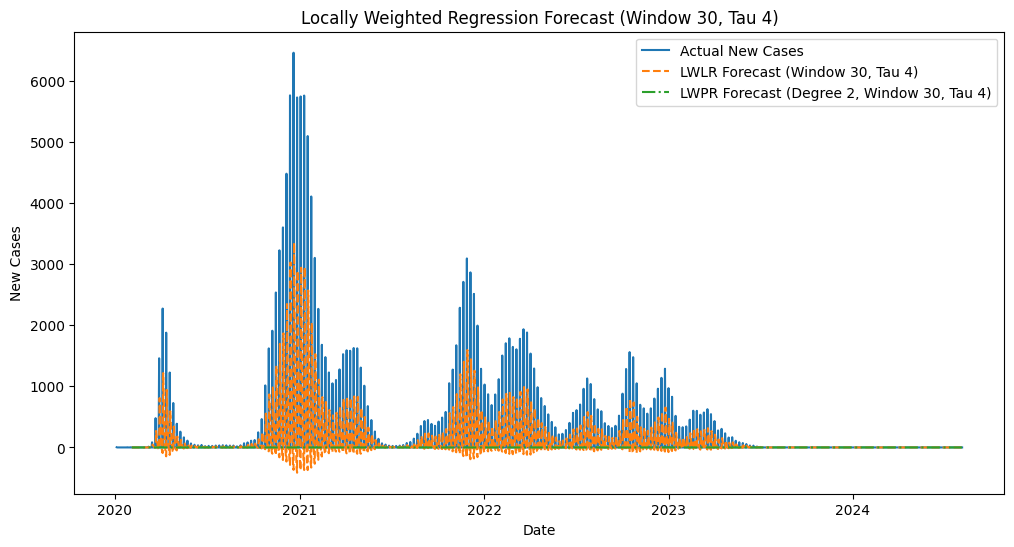

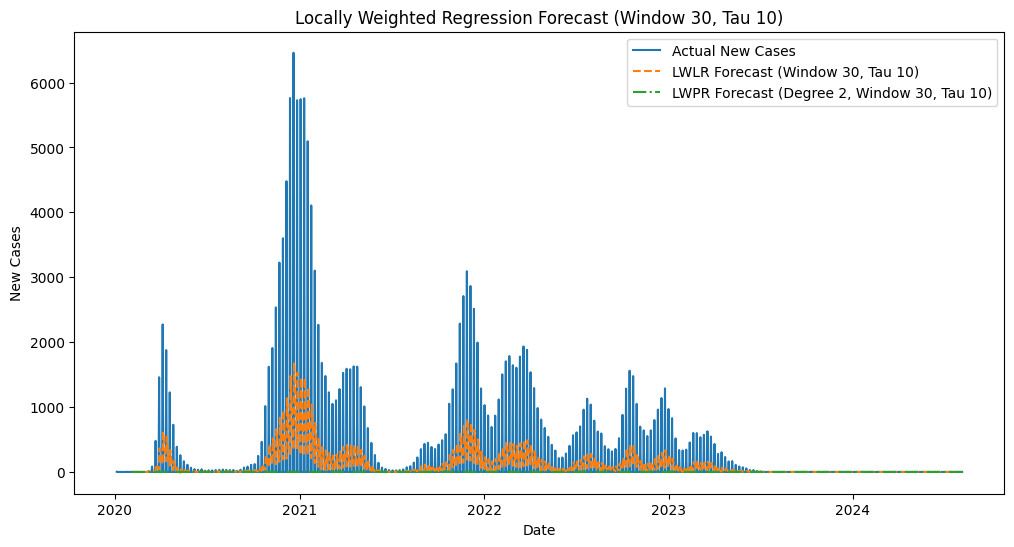

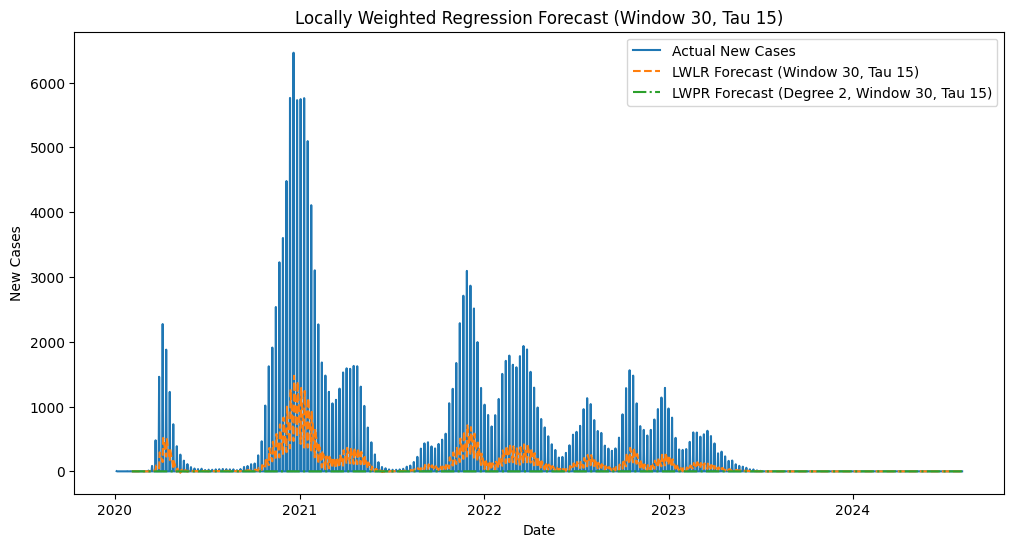

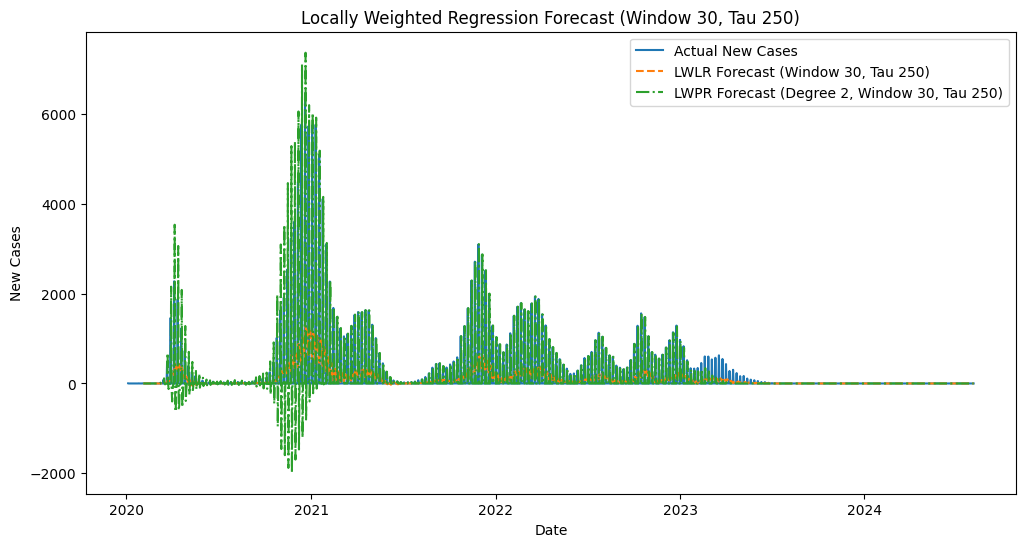

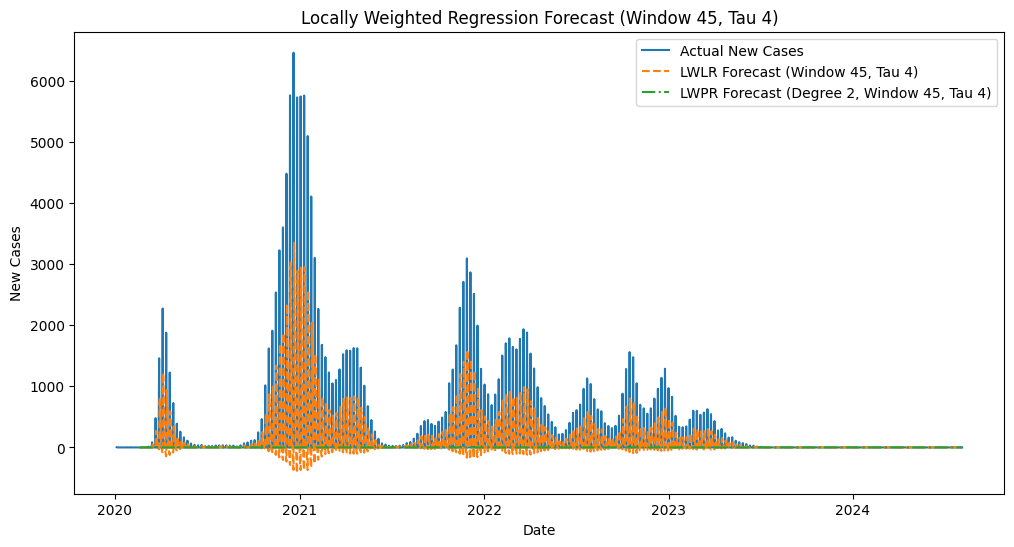

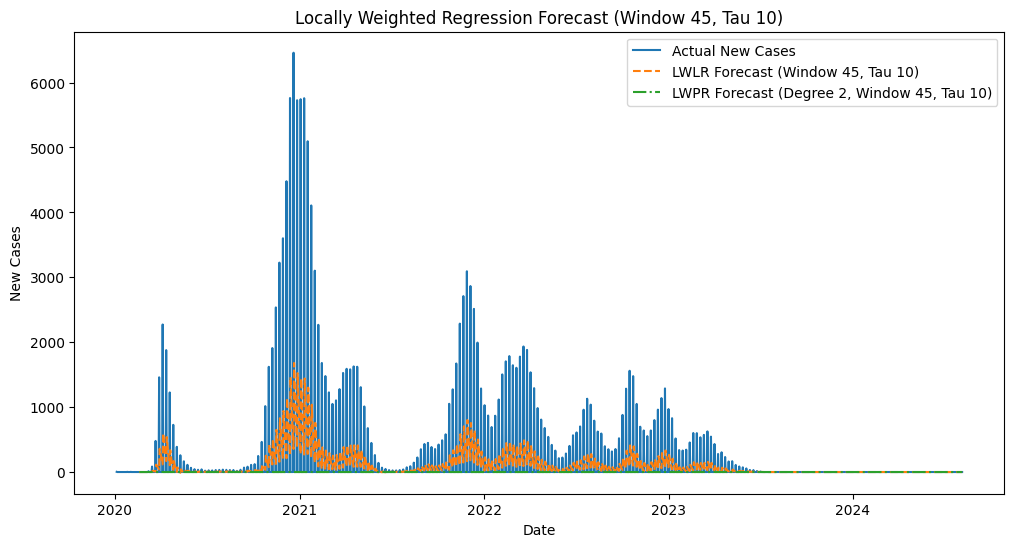

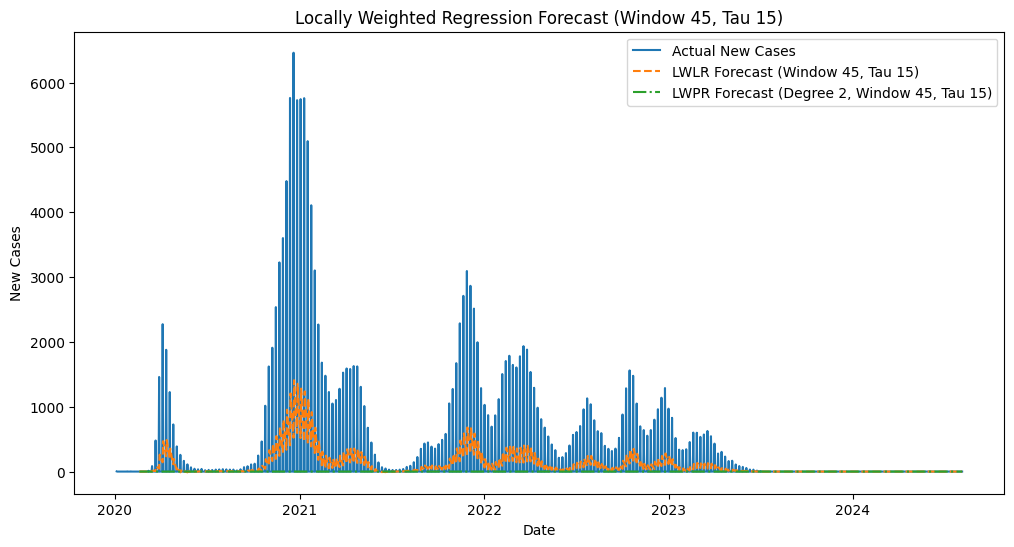

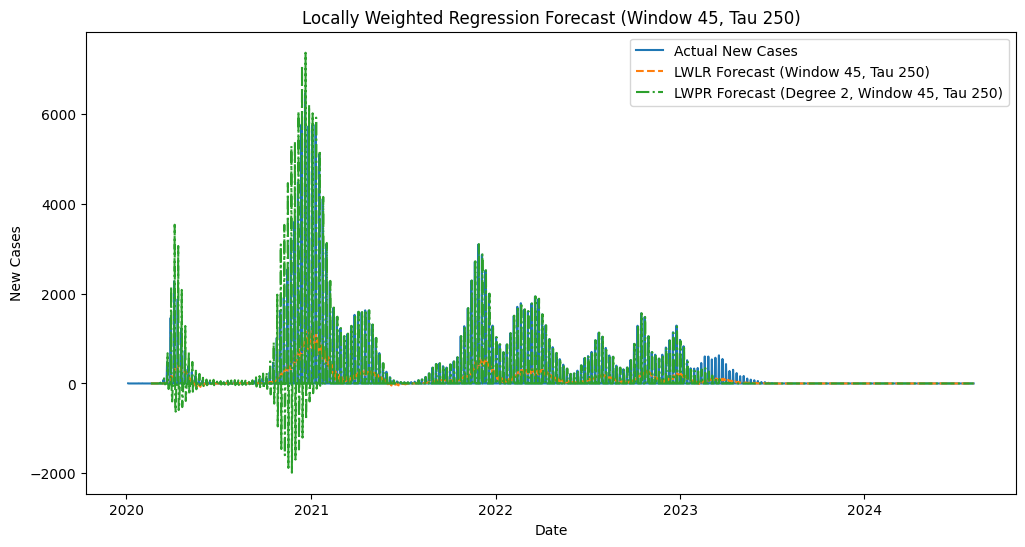

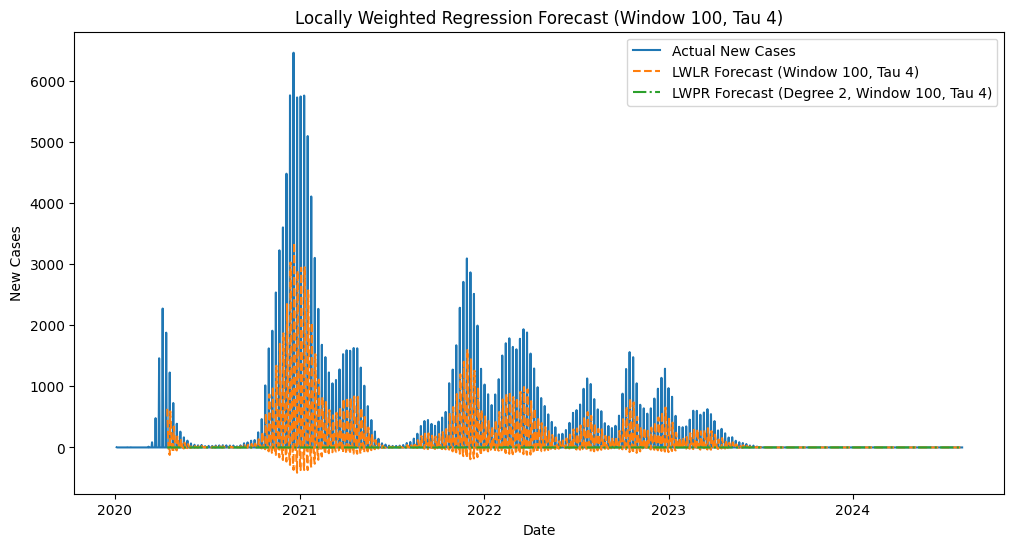

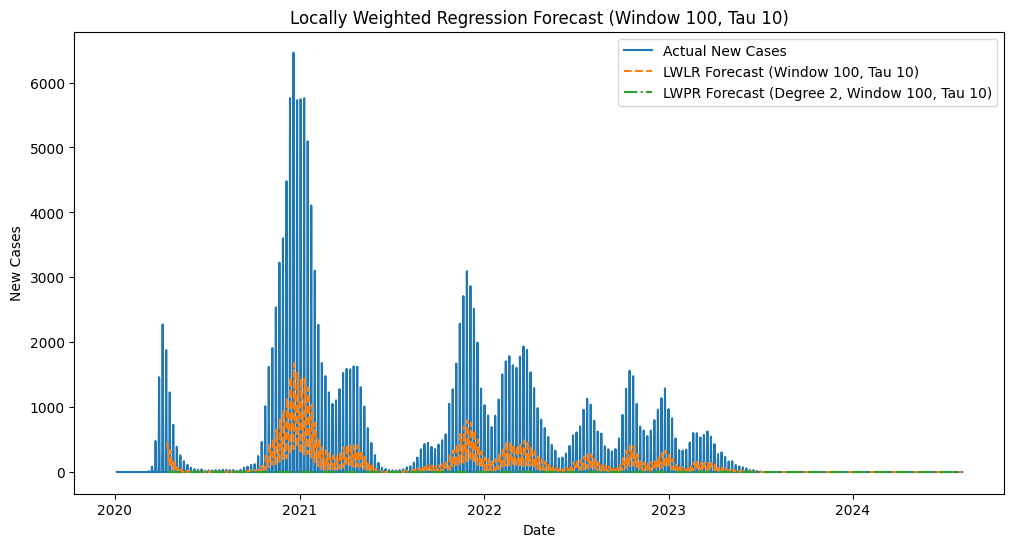

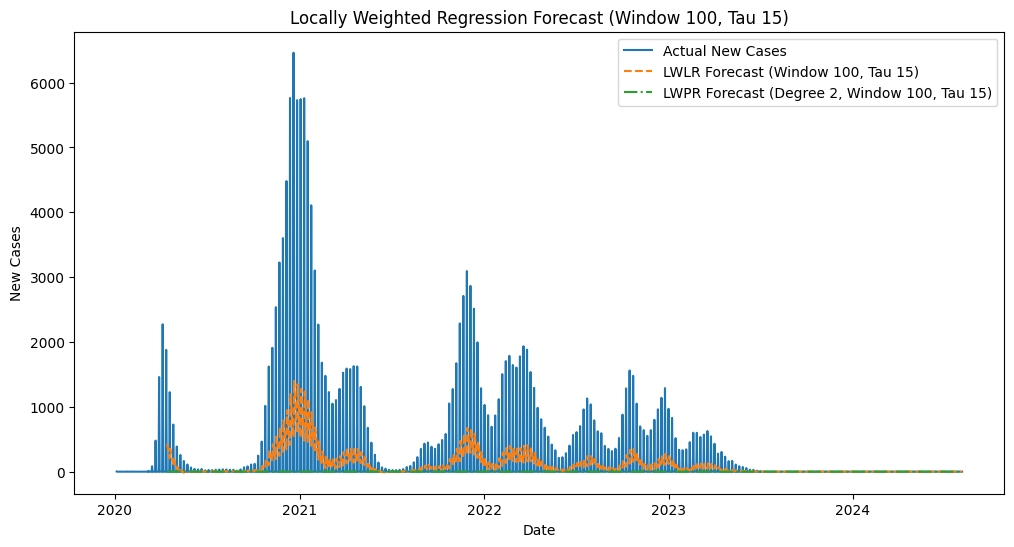

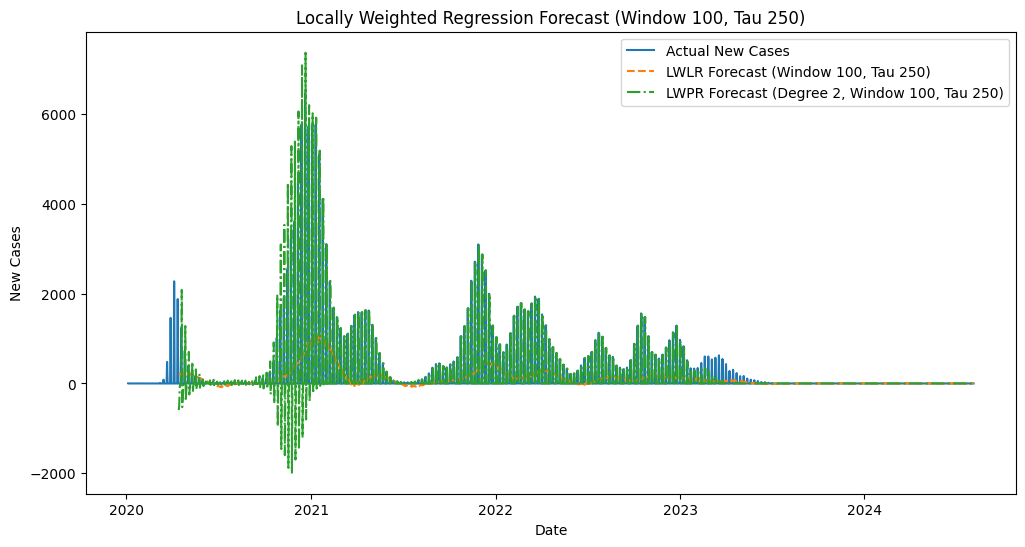

In [15]:
# Looping to see different values in place of WS and taus.

import numpy as np
import matplotlib.pyplot as plt

# Parameters for window sizes and tau values
window_sizes = [15, 30, 45, 100]
taus = [4, 10, 15, 250]

# Convert the date index to integer values for x-axis
country_data['time'] = np.arange(len(country_data))
x = country_data['time'].values
y = country_data['new_deaths'].values

# Loop through different window sizes and taus
for window_size in window_sizes:
    for tau in taus:
        forecast_lwlr = []
        forecast_lwpr = []
        
        for i in range(window_size, len(x)):
            # Define window for local regression
            x_window = x[i-window_size:i]
            y_window = y[i-window_size:i]

            # Current point to predict
            x0 = x[i]

            # Locally Weighted Linear Regression forecast
            y_lwlr = locally_weighted_linear_regression(x_window, y_window, x0, tau)
            forecast_lwlr.append(y_lwlr)

            # Locally Weighted Polynomial Regression forecast (degree 2)
            y_lwpr = locally_weighted_polynomial_regression(x_window, y_window, x0, tau, degree=2)
            forecast_lwpr.append(y_lwpr)

        # Adjust x values to align with forecast length
        x_forecast = x[window_size:]

        # Plot the forecasts for current window_size and tau
        plt.figure(figsize=(12, 6))
        plt.plot(country_data.index, country_data['new_deaths'], label='Actual New Cases')
        plt.plot(country_data.index[window_size:], forecast_lwlr, label=f'LWLR Forecast (Window {window_size}, Tau {tau})', linestyle='--')
        plt.plot(country_data.index[window_size:], forecast_lwpr, label=f'LWPR Forecast (Degree 2, Window {window_size}, Tau {tau})', linestyle='-.')
        plt.title(f'Locally Weighted Regression Forecast (Window {window_size}, Tau {tau})')
        plt.xlabel('Date')
        plt.ylabel('New Cases')
        plt.legend()
        plt.show()


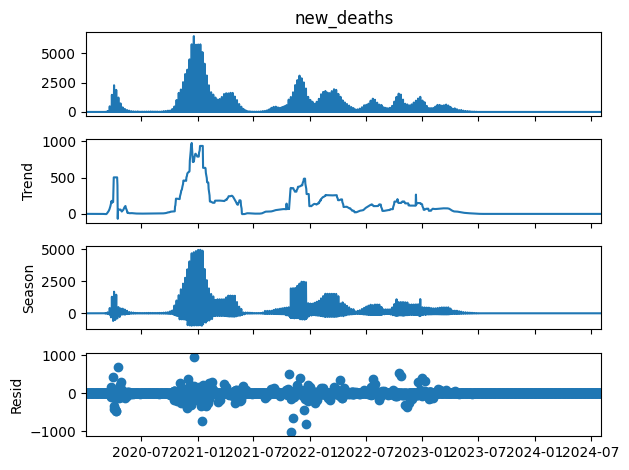

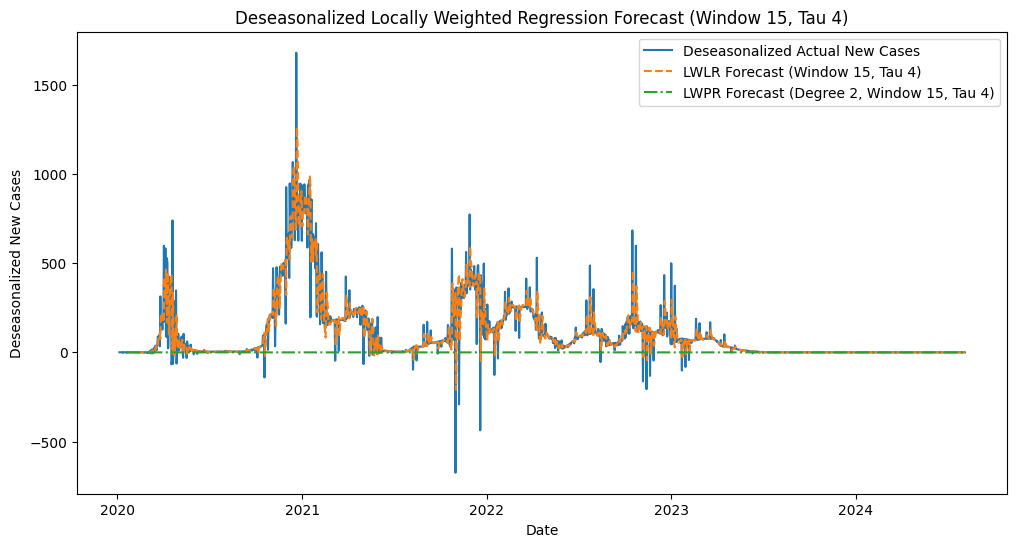

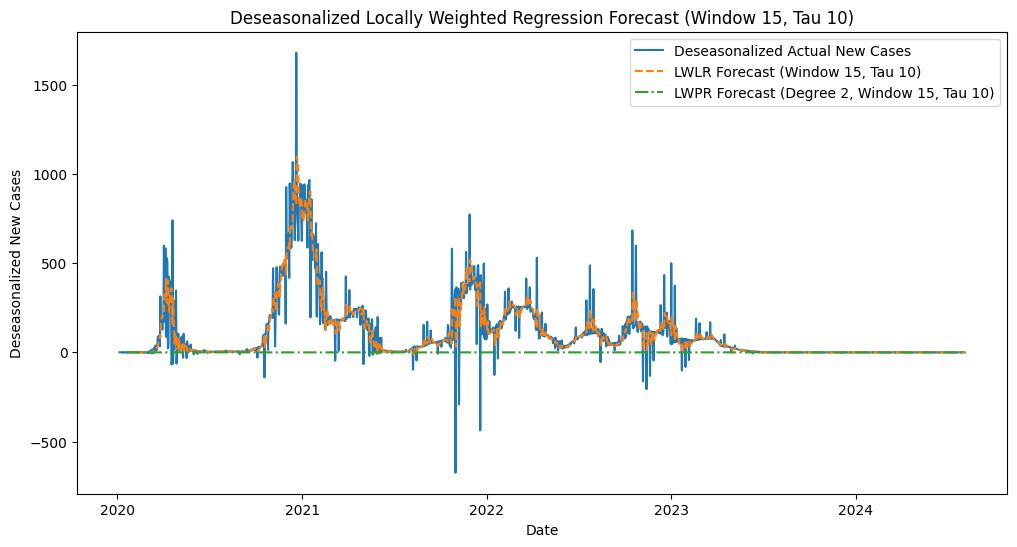

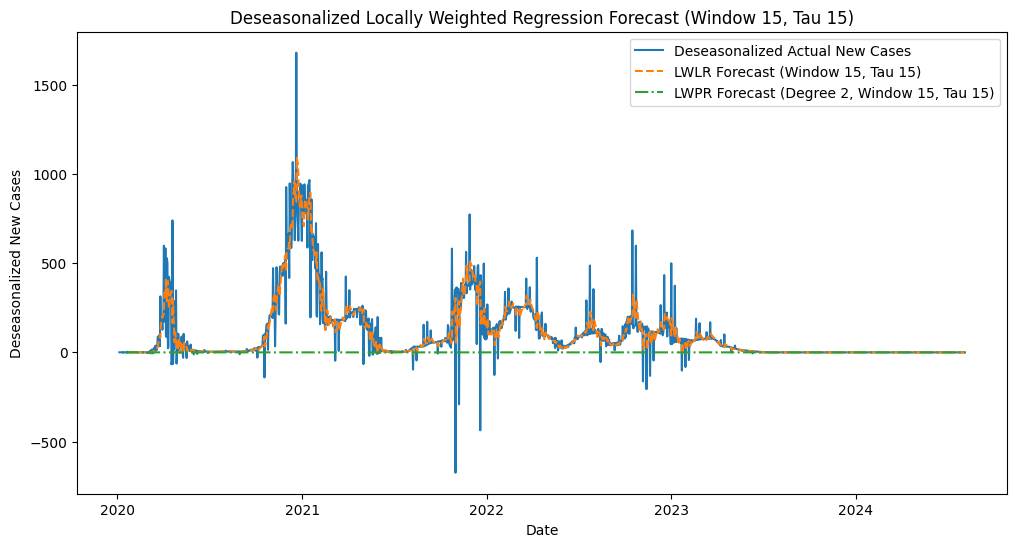

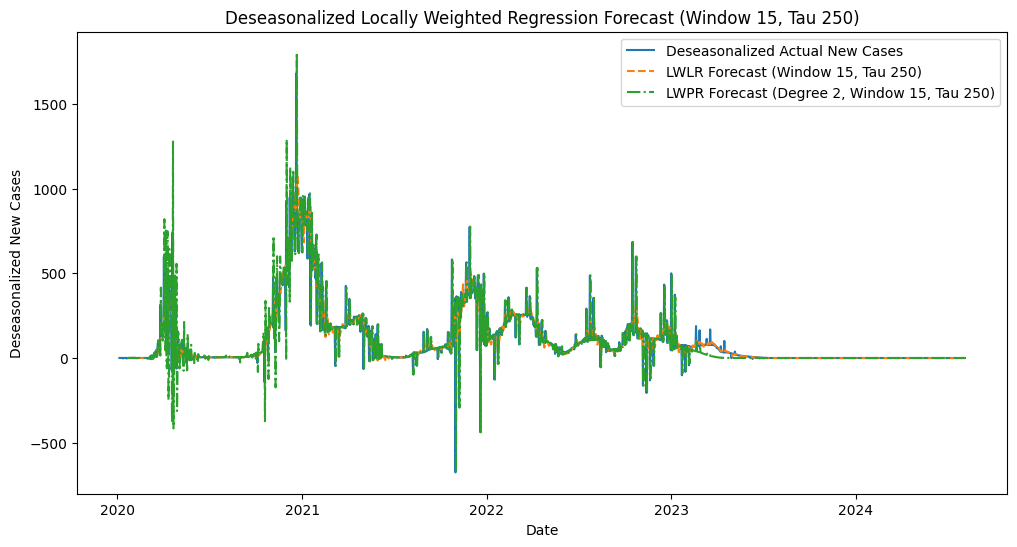

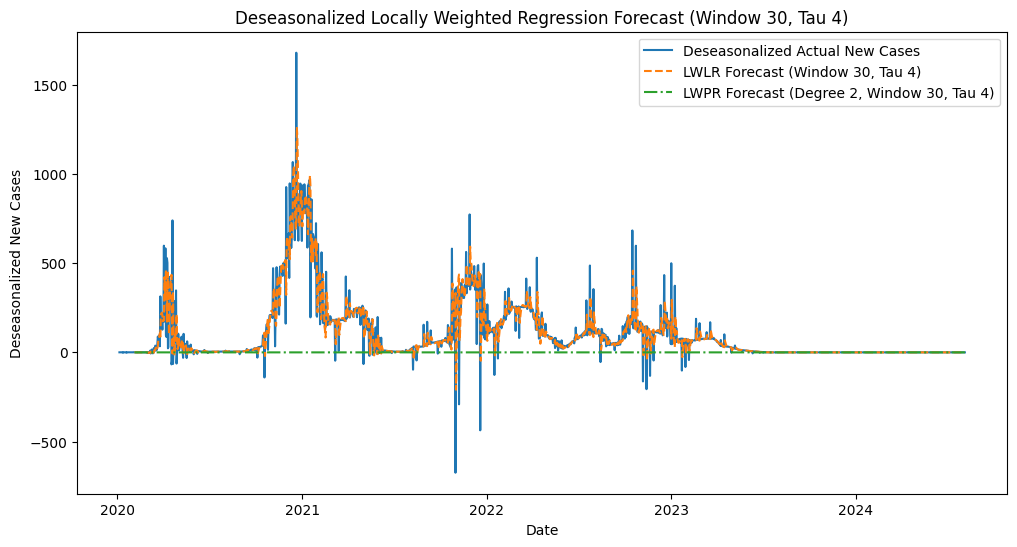

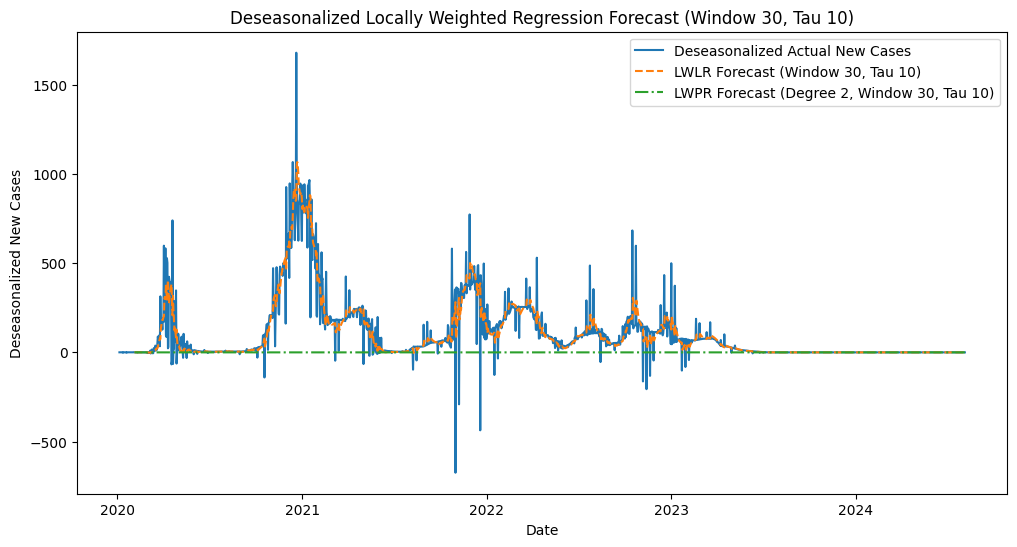

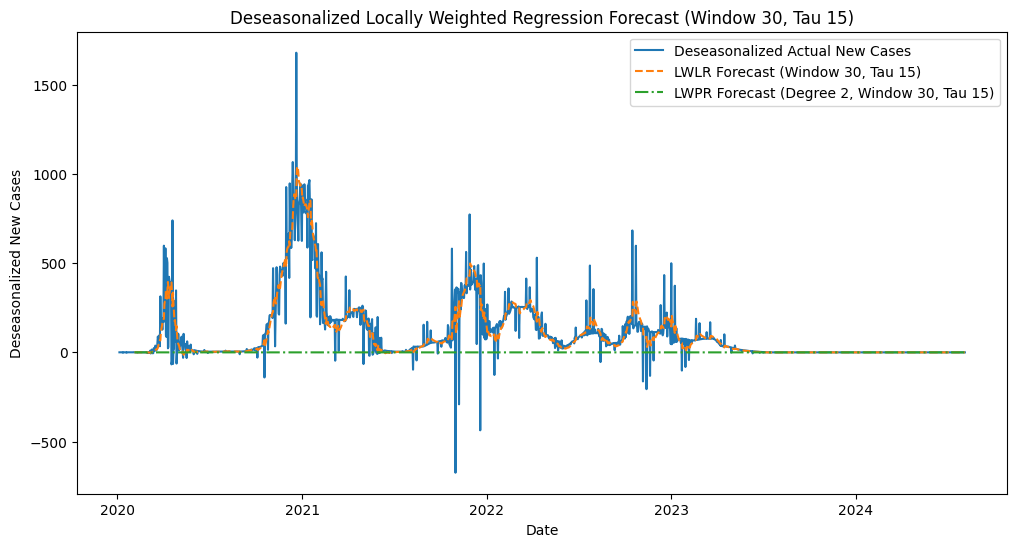

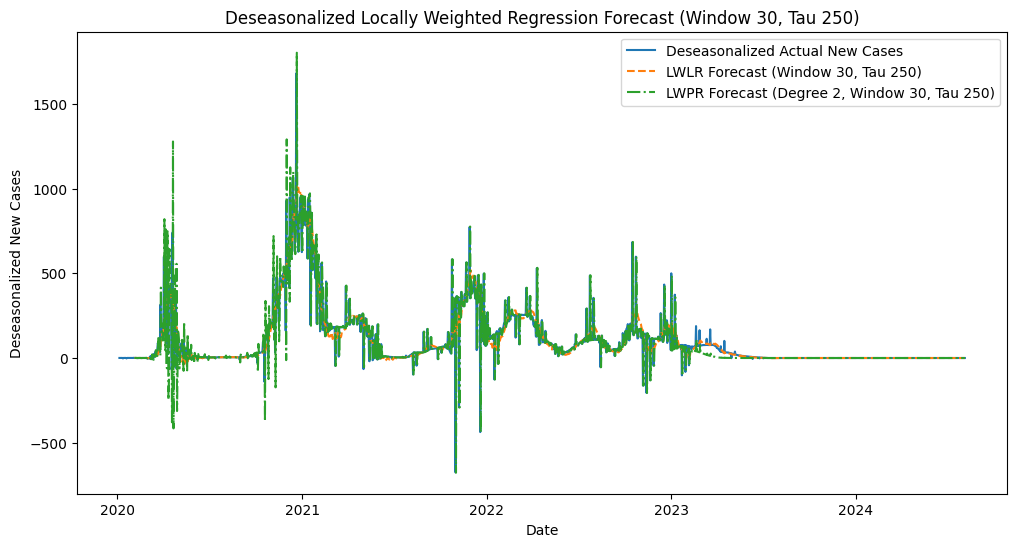

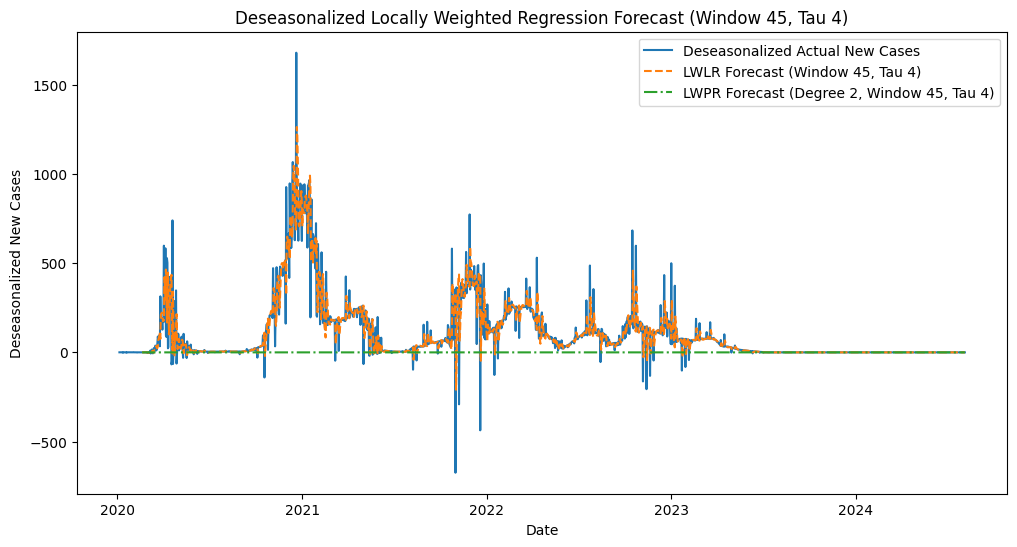

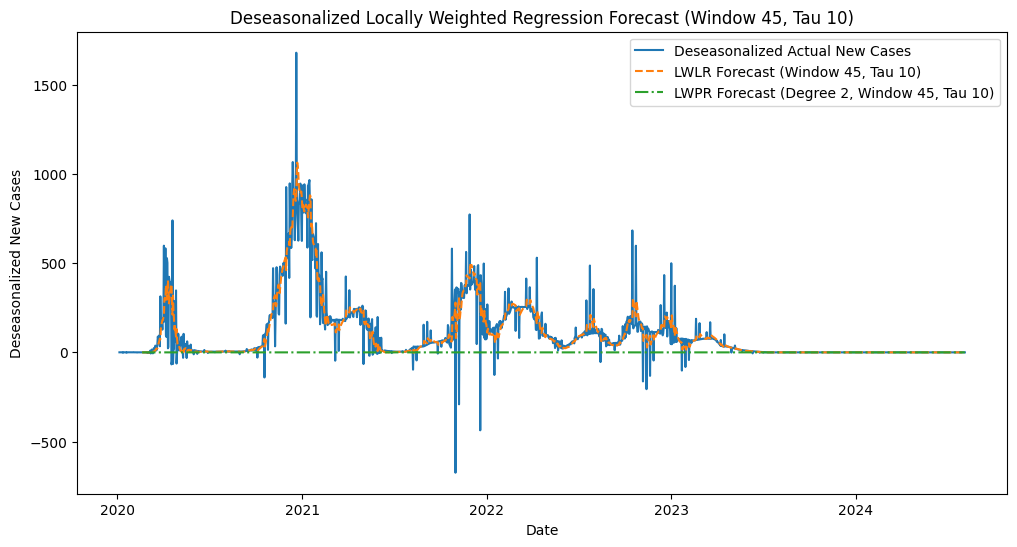

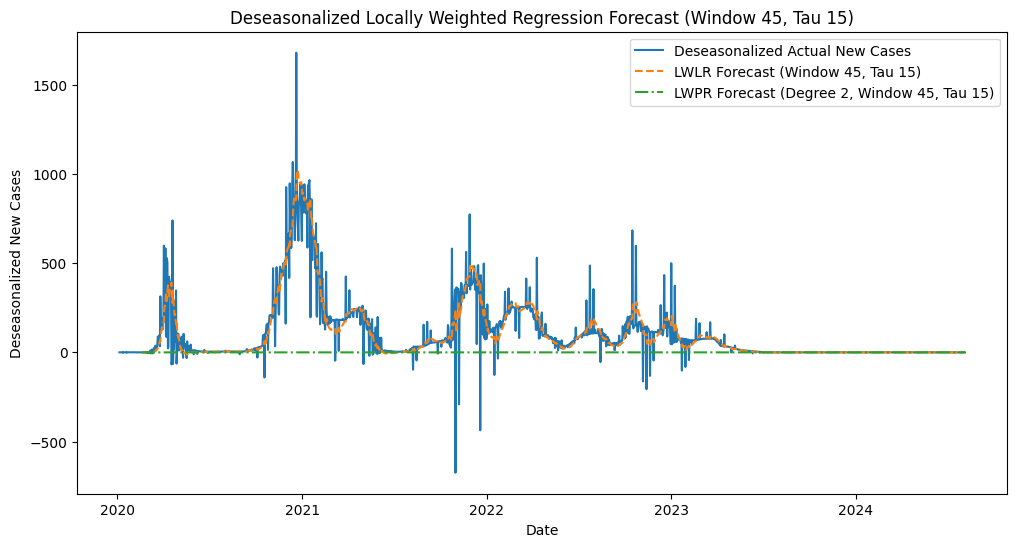

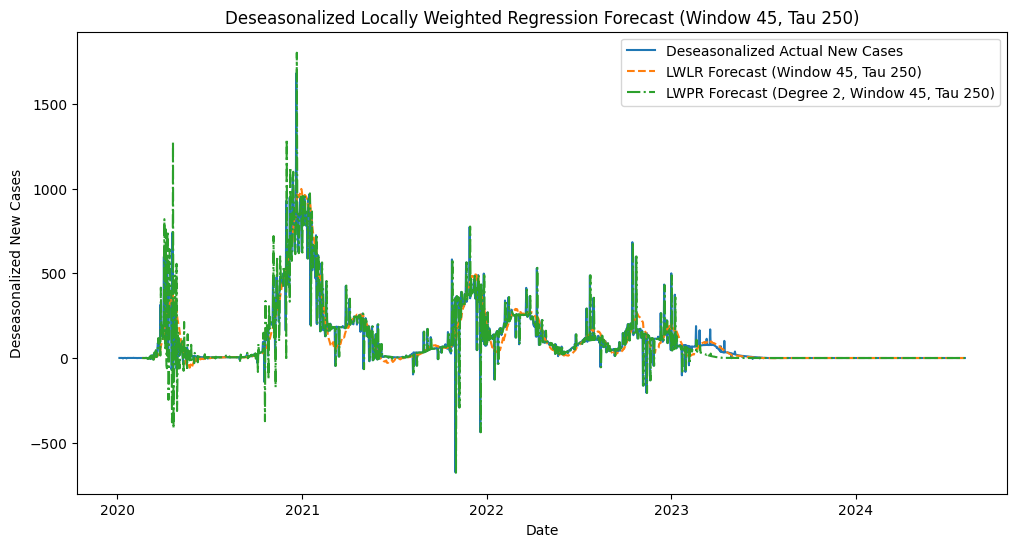

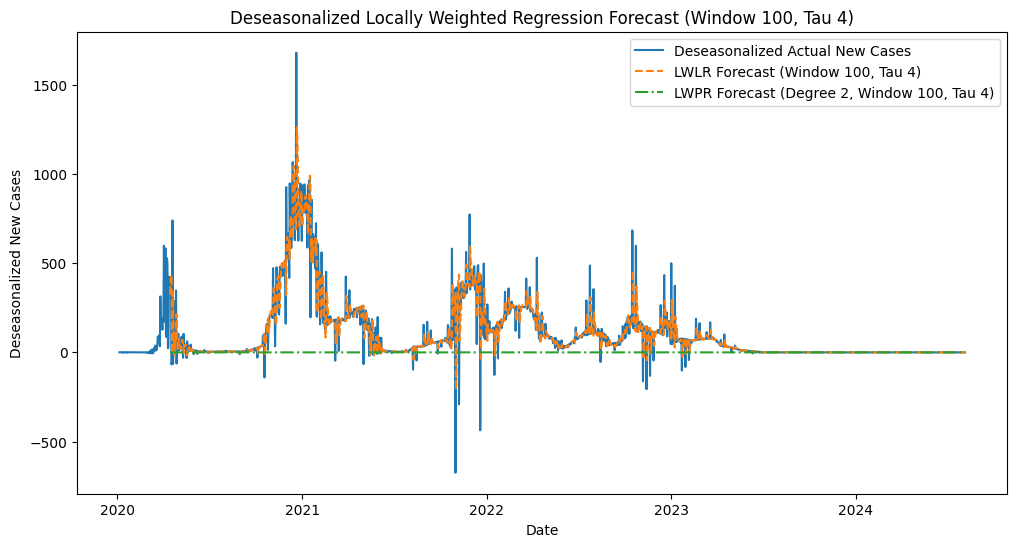

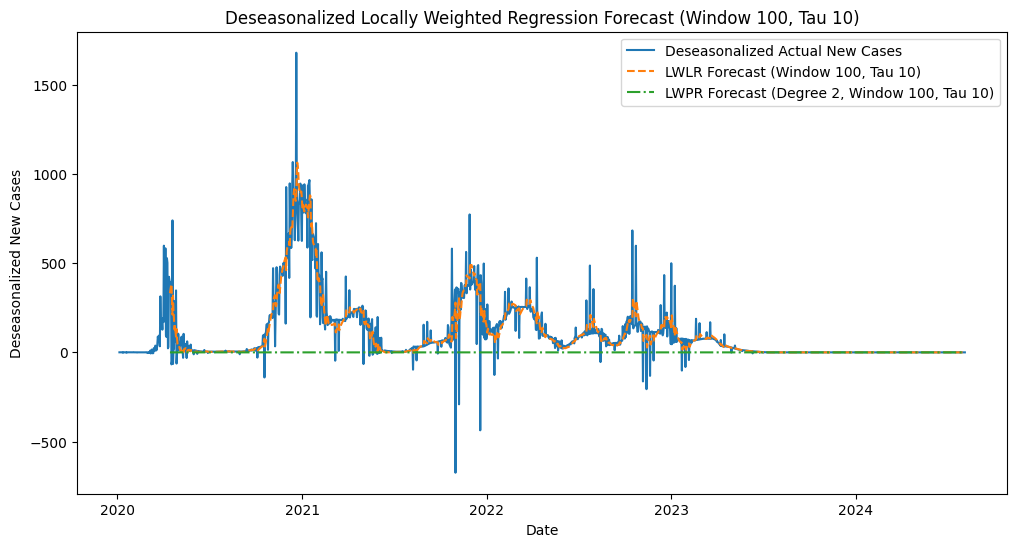

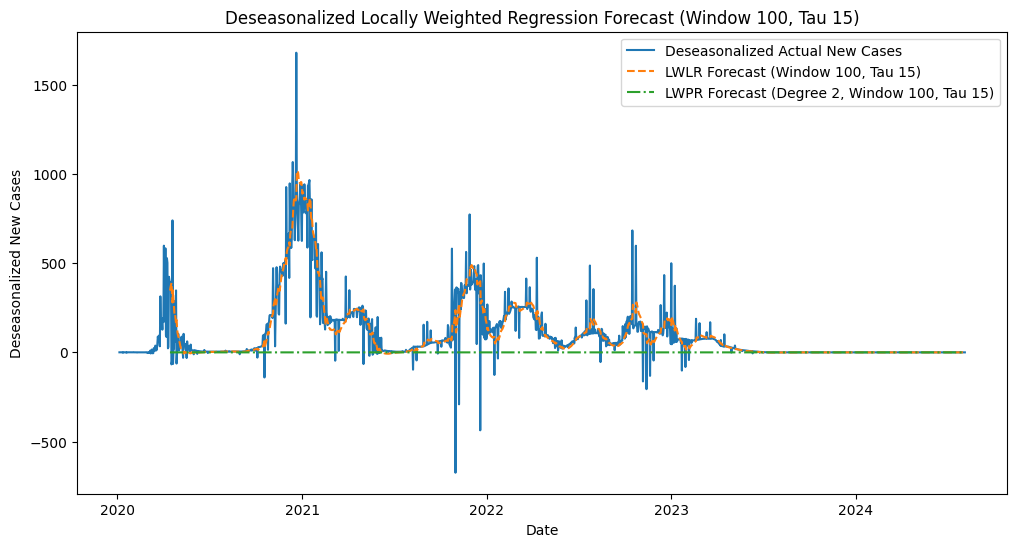

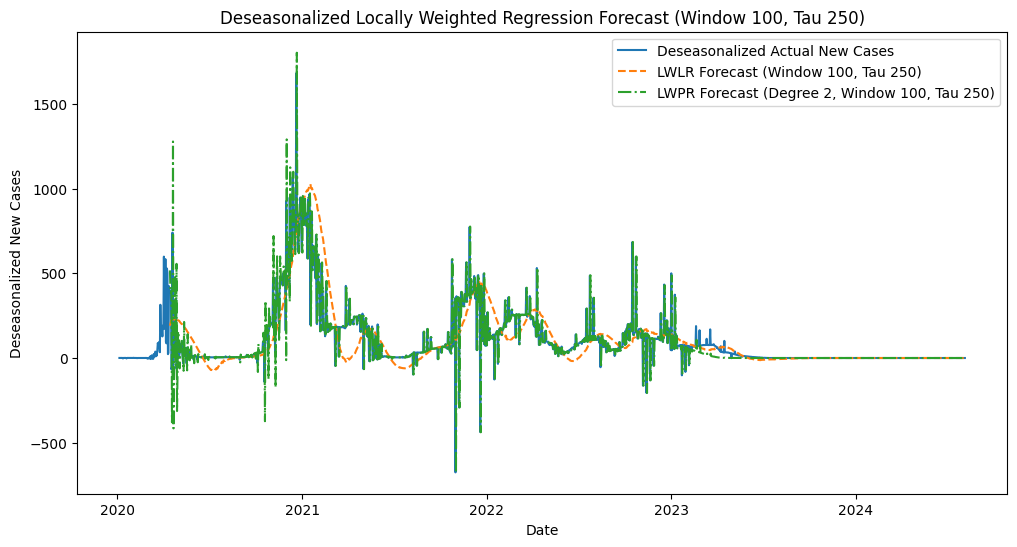

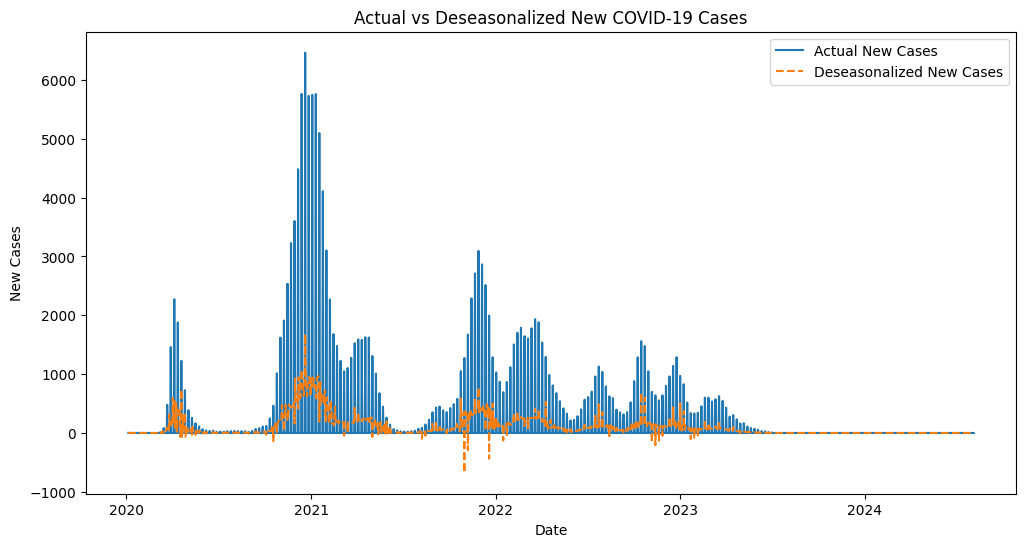

In [17]:

# Parameters for window sizes and tau values
window_sizes = [15, 30, 45, 100]
taus = [4, 10, 15, 250]

# Perform STL decomposition (Assume a seasonal period of 7 for weekly data)
seasonal_period = 7
deseasonalized_data, trend, seasonal, residual, stl_result = decompose_and_deseasonalize(country_data['new_deaths'], seasonal_period)

# Plot the decomposed components
stl_result.plot()
plt.show()

# Use deseasonalized data for forecasting
x = country_data['time'].values
y_deseasonalized = deseasonalized_data.values

# Loop through different window sizes and taus
for window_size in window_sizes:
    for tau in taus:
        forecast_lwlr = []
        forecast_lwpr = []
        
        for i in range(window_size, len(x)):
            # Define window for local regression
            x_window = x[i-window_size:i]
            y_window = y_deseasonalized[i-window_size:i]

            # Current point to predict
            x0 = x[i]

            # Locally Weighted Linear Regression forecast
            y_lwlr = locally_weighted_linear_regression(x_window, y_window, x0, tau)
            forecast_lwlr.append(y_lwlr)

            # Locally Weighted Polynomial Regression forecast (degree 2)
            y_lwpr = locally_weighted_polynomial_regression(x_window, y_window, x0, tau, degree=2)
            forecast_lwpr.append(y_lwpr)

        # Adjust x values to align with forecast length
        x_forecast = x[window_size:]

        # Plot the forecasts for current window_size and tau
        plt.figure(figsize=(12, 6))
        plt.plot(country_data.index, y_deseasonalized, label='Deseasonalized Actual New Cases')
        plt.plot(country_data.index[window_size:], forecast_lwlr, label=f'LWLR Forecast (Window {window_size}, Tau {tau})', linestyle='--')
        plt.plot(country_data.index[window_size:], forecast_lwpr, label=f'LWPR Forecast (Degree 2, Window {window_size}, Tau {tau})', linestyle='-.')
        plt.title(f'Deseasonalized Locally Weighted Regression Forecast (Window {window_size}, Tau {tau})')
        plt.xlabel('Date')
        plt.ylabel('Deseasonalized New Cases')
        plt.legend()
        plt.show()

# Plot the actual and deseasonalized data for comparison
plt.figure(figsize=(12, 6))
plt.plot(country_data.index, country_data['new_deaths'], label='Actual New Cases')
plt.plot(country_data.index, deseasonalized_data, label='Deseasonalized New Cases', linestyle='--')
plt.title('Actual vs Deseasonalized New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()


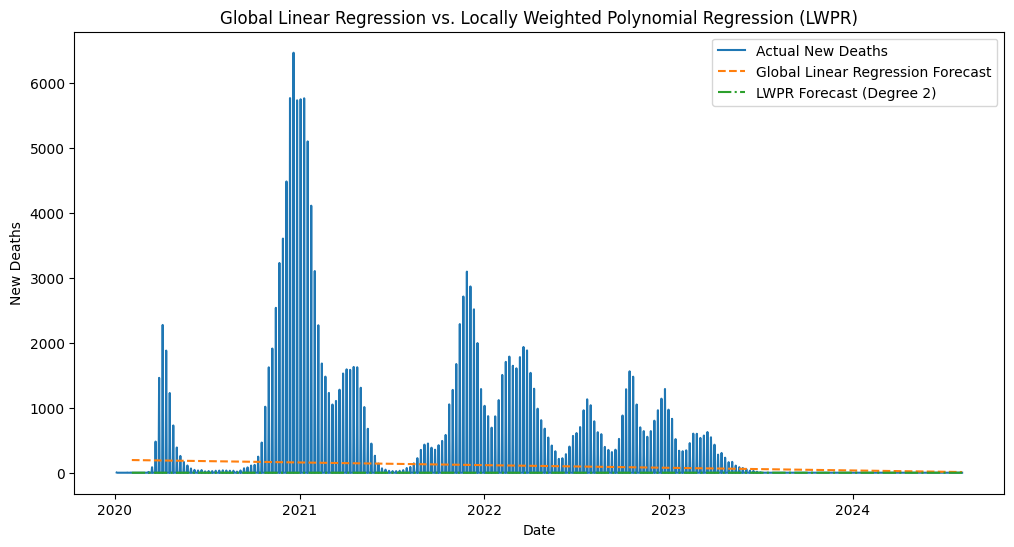

Global Linear Regression MSE: 252593.00936904957
Locally Weighted Polynomial Regression (LWPR) MSE: 267413.9902676399


In [14]:
## Comparison graph

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


# Prepare x and y values for locally weighted models
x = country_data['time'].values
y = country_data['new_deaths'].values

# Initialize forecast lists
forecast_global_lr = []
forecast_lwpr = []

# Fitting a global linear regression (global model)
global_model = LinearRegression(fit_intercept=True)
global_model.fit(x.reshape(-1, 1), y)
y_global_lr = global_model.predict(x.reshape(-1, 1))

# Sliding window forecast for the locally weighted model (local model)
for i in range(window_size, len(x)):
    # Define window for local regression
    x_window = x[i-window_size:i]
    y_window = y[i-window_size:i]

    # Current point to predict
    x0 = x[i]

    # Locally Weighted Polynomial Regression forecast
    y_lwpr = locally_weighted_polynomial_regression(x_window, y_window, x0, tau, degree=2)
    forecast_lwpr.append(y_lwpr)

# Forecast for the remaining part of global linear regression
forecast_global_lr = y_global_lr[window_size:]

# Plot the forecasts
x_forecast = x[window_size:]

plt.figure(figsize=(12, 6))
plt.plot(country_data.index, country_data['new_deaths'], label='Actual New Deaths')
plt.plot(country_data.index[window_size:], forecast_global_lr, label='Global Linear Regression Forecast', linestyle='--')
plt.plot(country_data.index[window_size:], forecast_lwpr, label='LWPR Forecast (Degree 2)', linestyle='-.')
plt.title('Global Linear Regression vs. Locally Weighted Polynomial Regression (LWPR)')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE) for comparison
mse_global_lr = mean_squared_error(y[window_size:], forecast_global_lr)
mse_lwpr = mean_squared_error(y[window_size:], forecast_lwpr)

print(f"Global Linear Regression MSE: {mse_global_lr}")
print(f"Locally Weighted Polynomial Regression (LWPR) MSE: {mse_lwpr}")
